In [1]:
# from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import os
import json
import numpy as np

import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data

from model import SSD300, MultiBoxLoss
from datasets import *


## Declare useful constants

In [36]:
# params
data_folder = './voc/'  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8
num_workers = 6
checkpoint = './SSD_40_epochs_dropout_0.1.pth.tar'

results_dir = './results/final_small_batch/'

# load training data
with open(os.path.join(data_folder, 'TRAIN_images.json'), 'r') as j:
    train_images = json.load(j)
with open(os.path.join(data_folder, 'TRAIN_objects.json'), 'r') as j:
    train_objects = json.load(j)

#VOC2007 has 5011 training instances
#train_images loaded in order, so just grab first 5011
all_train_indices = np.arange(len(train_images))
train_indices = all_train_indices[:5011] 

#note:, replaced "background" with "> 1cls"
label_to_num = {"aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4, "bottle": 5, 
                "bus": 6, "car": 7, "cat": 8, "chair": 9, "cow": 10, "diningtable": 11, 
                "dog": 12, "horse": 13, "motorbike": 14, "person": 15, "pottedplant": 16, 
                "sheep": 17, "sofa": 18, "train": 19, "tvmonitor": 20, "> 1 cls": 0} 
num_to_label = {v: k for k, v in label_to_num.items()}

distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', 
                   '#46f0f0', '#f032e6', '#d2f53c', '#fabebe', '#008080', '#000080', 
                   '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
                   '#e6beff', '#808080', '#FFFFFF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_to_num.keys())}

afs = ['MARGIN_SAMPLING', 'RANDOM', 'LOCALIZATION_STABILITY', 'MEAN_STD', 'ENTROPY',\
       'BALD', 'VAR_RATIO', 'MEAN_STD_WITH_BBOX', 'QBC']



## Get Activation Maps from SSD 

In [3]:
# Custom dataloaders
train_dataset = TrainDataset(train_images, train_objects, train_indices,
                                keep_difficult=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                            collate_fn=train_dataset.collate_fn, num_workers=num_workers,
                                            pin_memory=True)  # note that we're passing the collate function here

# load checkpoint
checkpoint = torch.load(checkpoint)
print("Loading checkpoint model.")
model = checkpoint['model']
optimizer = checkpoint['optimizer']

# Convenient function to visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.base.conv5_3.register_forward_hook(get_activation('conv5_3'))

print("train images len: ", len(train_indices))
total_batches = int( len(train_indices) / batch_size )

all_activations = []
all_labels = []
for i, (images, boxes, labels, _) in enumerate(train_loader):
    print("batch #: ", i, " / ", total_batches)
    # Move to default device
    images = images.to(device)  # (batch_size (N), 3, 300, 300)
    boxes = [b.to(device) for b in boxes]
    labels = [l.to(device) for l in labels] # (batch_size, num_bboxes)

    # Forward prop.
    predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

    act = activation['conv5_3'].squeeze()

    for j in range(images.shape[0]):
        img_act = torch.flatten(act[j, :, :, :]).cpu().numpy()
        # print(img_act)
        all_activations.append(img_act)

        img_label = labels[j]
        # either one cls or more than one cls
        if (img_label == img_label[0]).all() :
            all_labels.append( img_label[0].item()  )
        else:
            all_labels.append( label_to_num["> 1 cls"] )

print("done iterating training data")
all_activations = np.array(all_activations)
all_labels = np.array(all_labels)


Loading checkpoint model.
train images len:  5011


/home/christopherchan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'model.SSD300' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


batch #:  0  /  626
batch #:  1  /  626
batch #:  2  /  626
batch #:  3  /  626
batch #:  4  /  626
batch #:  5  /  626
batch #:  6  /  626
batch #:  7  /  626
batch #:  8  /  626
batch #:  9  /  626
batch #:  10  /  626
batch #:  11  /  626
batch #:  12  /  626
batch #:  13  /  626
batch #:  14  /  626
batch #:  15  /  626
batch #:  16  /  626
batch #:  17  /  626
batch #:  18  /  626
batch #:  19  /  626
batch #:  20  /  626
batch #:  21  /  626
batch #:  22  /  626
batch #:  23  /  626
batch #:  24  /  626
batch #:  25  /  626
batch #:  26  /  626
batch #:  27  /  626
batch #:  28  /  626
batch #:  29  /  626
batch #:  30  /  626
batch #:  31  /  626
batch #:  32  /  626
batch #:  33  /  626
batch #:  34  /  626
batch #:  35  /  626
batch #:  36  /  626
batch #:  37  /  626
batch #:  38  /  626
batch #:  39  /  626
batch #:  40  /  626
batch #:  41  /  626
batch #:  42  /  626
batch #:  43  /  626
batch #:  44  /  626
batch #:  45  /  626
batch #:  46  /  626
batch #:  47  /  626
ba

batch #:  379  /  626
batch #:  380  /  626
batch #:  381  /  626
batch #:  382  /  626
batch #:  383  /  626
batch #:  384  /  626
batch #:  385  /  626
batch #:  386  /  626
batch #:  387  /  626
batch #:  388  /  626
batch #:  389  /  626
batch #:  390  /  626
batch #:  391  /  626
batch #:  392  /  626
batch #:  393  /  626
batch #:  394  /  626
batch #:  395  /  626
batch #:  396  /  626
batch #:  397  /  626
batch #:  398  /  626
batch #:  399  /  626
batch #:  400  /  626
batch #:  401  /  626
batch #:  402  /  626
batch #:  403  /  626
batch #:  404  /  626
batch #:  405  /  626
batch #:  406  /  626
batch #:  407  /  626
batch #:  408  /  626
batch #:  409  /  626
batch #:  410  /  626
batch #:  411  /  626
batch #:  412  /  626
batch #:  413  /  626
batch #:  414  /  626
batch #:  415  /  626
batch #:  416  /  626
batch #:  417  /  626
batch #:  418  /  626
batch #:  419  /  626
batch #:  420  /  626
batch #:  421  /  626
batch #:  422  /  626
batch #:  423  /  626
batch #:  

## Apply PCA and T-SNE on activation maps

In [16]:
# takes a while
print("Doing pca")

pca_20 = PCA(n_components=20) # 184832 features, should be less than 4000
pca_result_20 = pca_20.fit_transform(all_activations)

print("Done pca")

print("Doing tsne")

# apply tsne
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(pca_result_20)

print("Done tsne")

Doing pca
Done pca
Doing tsne
Done tsne


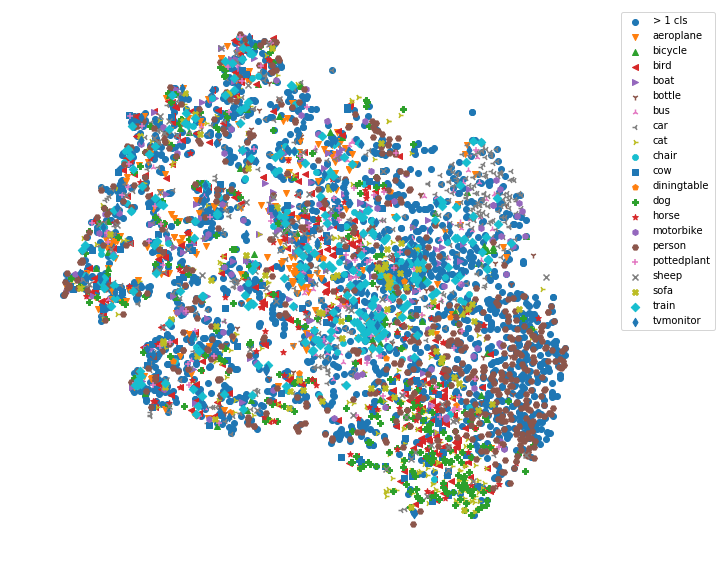

In [67]:
markers = ["o" ,"v" ,"^" ,"<" ,">" ,"1" ,"2" ,"3" ,"4" ,"8" ,
           "s" ,"p" ,"P" ,"*" ,"h" ,"H" ,"+" ,"x" ,"X" ,"D" ,\
           "d" ]
plt.figure(figsize=(10,10))

# Plotting
for i in range(21):
    indices = all_labels == i
    plt.scatter(X_2d[all_labels == i, 0], X_2d[all_labels == i, 1], \
                label=num_to_label[i], marker = markers[i])
lgd = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.axis('off')
plt.savefig("images/tsne/voc_2007_tsne.png", \
            bbox_extra_artists=(lgd,), bbox_inches='tight' )


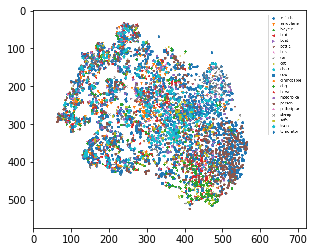

In [68]:
img = mpimg.imread('images/tsne/voc_2007_tsne.png')
plt.imshow(img)
plt.show()

[872, 782, 566, 1300, 3203, 3542, 2448, 3680, 1681, 3495]
[2196, 3704, 3464, 3683, 4060, 4471, 2360, 3669, 4157, 3198]
[2569, 1297, 4589, 2836, 4663, 1118, 3494, 1979, 3005, 1838]
[4125, 1395, 674, 4048, 1150, 3651, 4624, 3615, 4065, 2179]
[4189, 4125, 3031, 2864, 1488, 3743, 1274, 2983, 1886, 4300]
[2188, 1747, 528, 1177, 1110, 2981, 3877, 880, 788, 1014]
[4189, 2864, 1021, 3651, 3938, 2220, 3611, 1663, 760, 3729]
[4699, 700, 2271, 4719, 3453, 1048, 568, 3298, 2318, 2540]
[2351, 3563, 526, 1446, 3869, 2840, 4920, 1345, 4761, 794]


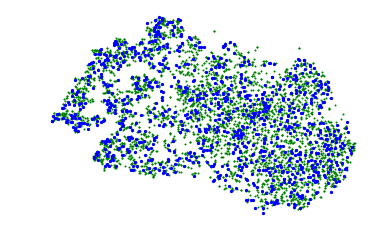

In [63]:

for af in afs:
    file_str = results_dir + af + '_' + str(1) + '_test_acc.npy.npz'
    
    plt.clf()
    
    # all possible coords
    plt.scatter(X_2d[:, 0], X_2d[:, 1], s=1, c='g')

    npzfile = np.load(file_str, allow_pickle=True)
    training_data = npzfile['training_data']
    acc = npzfile['mAP_list']

    flat_list = []
    for sublist in training_data:
        for item in sublist:
            flat_list.append(item)
            
    flat_list = flat_list[500:1500]
    print(flat_list[:10])


    plt.scatter(X_2d[flat_list, 0], X_2d[flat_list, 1], s=5, c='b')

    plt.axis('off')
    
    save_string = 'images/tsne/' + af + '_tsne.png'
    plt.savefig(save_string)


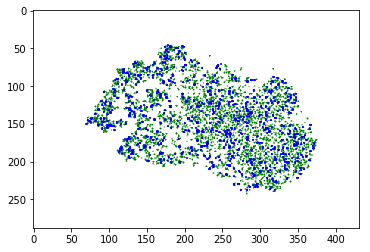

In [59]:
img = mpimg.imread('images/tsne/' + 'QBC' + '_tsne.png')
plt.imshow(img)
plt.show()

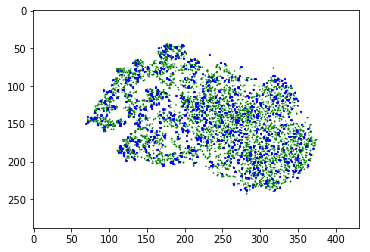

In [61]:
img = mpimg.imread('images/' + 'RANDOM' + '_tsne.png')
plt.imshow(img)
plt.show()